In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.feature_map import ChebPQC
from squlearn.expectation_operator import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam

In [2]:
executor = Executor("statevector_simulator")

Define parameterized quantum circuit $Q(x,\theta)$

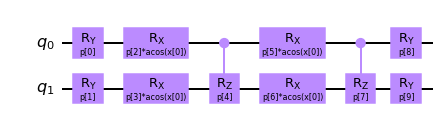

In [3]:
nqubits = 2
pqc = ChebPQC(num_qubits=nqubits, num_features=1, num_layers=2)
pqc.draw()

Definition of the cost operator:
$\hat{H} = J \sum\limits_{i < j} Z_i Z_j + h\sum\limits_i Z_i + c$

In [4]:
op = SummedPaulis(2)
print(op)

SparsePauliOp(['II', 'IZ', 'ZI'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2])])


Example function: $log(x)$

In [5]:
x_space = np.arange(-0.5, 0.6, 0.1)
ref_values = np.square(x_space)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.ones(op.num_parameters)

reg = QNNRegressor(pqc, op, executor, SquaredLoss(), Adam({"lr":0.1}), param_ini, param_op_ini)

Optimization of the regression

In [6]:
reg.fit(x_space, ref_values)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 1.         1.
 1.        ]
Current value: 3.1574234434268873
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 1.         1.
 1.        ]
Grad length: 16.201510077854078
grad [-1.11504426 -1.29234082  4.15922153 -2.78467197 -3.83681428  5.77086431
 -0.72177487 -1.22630784  3.55182494 -0.64637157 -8.50578704  6.93199853
  7.14414841]
theta [0.8777024  0.33754121 0.72427854 1.06574919 1.07260111 0.35344925
 0.70904245 0.87552651 0.54161335 0.82201821 1.1        0.9
 0.9       ]
Current value: 0.36589969254421895
theta [0.8777024  0.33754121 0.72427854 1.06574919 1.07260111 0.35344925
 0.70904245 0.87552651 0.54161335 0.82201821 1.1        0.9
 0.9       ]
Grad length: 3.6826976777163547
grad [-1.05367254 -0.24917964 -0.52277904 -2.27789673  0.30133273 -1.0715219
 -1.97074404 -0.03661961 -0.31319691 -0.517

In [7]:
print("Result Param:", reg.param)
print("Result ParamOp:", reg.param_op)

Result Param: [1.65135232 0.66524017 0.94685078 0.96012197 1.07676122 0.50876202
 0.97004195 0.64628971 0.84914015 0.66567045]
Result ParamOp: [0.94664274 0.41717632 0.89088529]


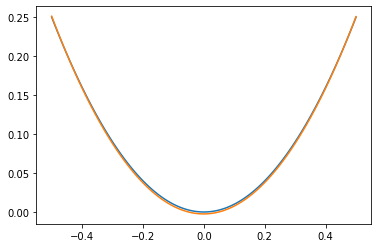

In [8]:
x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = reg.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator
from qiskit_aer.noise import NoiseModel

service = QiskitRuntimeService(channel="ibm_quantum",token="1e1fcef3940bc7181262dbc135a052e83b17a669f187b1d6d7bde96ef3167078b55eb494f44f3b3de8ea934023da7a5eef3df4c6d27bf8ce7d48ca174c654cb7")
noisy_backend = service.get_backend('ibm_nairobi')
backend_noise_model = NoiseModel.from_backend(noisy_backend)
simulator = service.get_backend('ibmq_qasm_simulator')
session = Session(service,backend=simulator)

C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:133: UserWarning: The model is not fitted.
  warn("The model is not fitted.")


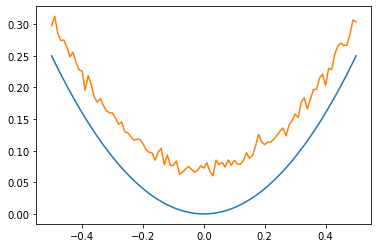

In [10]:
options = Options()
options.resilience_level = 0
options.optimization_level = 0
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": noisy_backend.configuration().coupling_map
}
options.execution.shots = 10000

executor_backend = Executor(Estimator(session,options),caching=False)
qnn_backend = QNNRegressor(pqc, op, executor_backend, SquaredLoss(), Adam(), reg.param, reg.param_op)
x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = qnn_backend.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 1.         1.
 1.        ]
Current value: 2.1153665200000002
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 1.         1.
 1.        ]
Grad length: 11.22253532649513
grad [-1.154012   -1.0135024   2.48524226 -2.8407259  -2.55589868  3.52572411
 -1.31019101 -0.90248604  2.27398184 -0.73791732 -5.962       4.70392064
  4.94549864]
theta [0.82770241 0.28754122 0.77427853 1.0157492  1.02260111 0.40344925
 0.65904246 0.82552651 0.59161335 0.77201822 1.05       0.95
 0.95      ]
Current value: 0.7263497578922127
theta [0.82770241 0.28754122 0.77427853 1.0157492  1.02260111 0.40344925
 0.65904246 0.82552651 0.59161335 0.77201822 1.05       0.95
 0.95      ]
Grad length: 5.356285383581556
grad [-1.11461026 -0.58661856  0.61877498 -3.24181434 -0.75344364  0.70283882
 -2.23699228 -0.53393648  0.95632138 -0.840

Traceback (most recent call last):
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\requests\adapters.py", line 486, in send
    resp = conn.urlopen(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py", line 876, in urlopen
    return self.urlopen(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py", line 876, in urlopen
    return self.urlopen(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py", line 876, in urlopen
    return self.urlopen(
  [Previous line repeated 2 more times]
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py", line 866, in urlopen
    retries = retries.increment(method, url, response=response, _pool=self)
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit_ibm_runtime\api\session.py", line 121, in increment
    return super().increment(
  File "C:\User

Grad length: 5.186745832367897
grad [ 0.00704618 -0.14081269  0.63425705 -1.26289094 -1.06938748  1.4238625
  0.22450001 -0.70885623  1.61999279  0.26041712 -3.2683416   1.64347204
  2.25525533]
theta [1.19410832 0.63001407 0.82519997 1.12188293 1.01830192 0.46793399
 0.91541357 0.76454969 0.67458777 0.98450241 0.99612199 0.83906411
 0.94251326]
Current value: 0.2815793335995391
theta [1.19410832 0.63001407 0.82519997 1.12188293 1.01830192 0.46793399
 0.91541357 0.76454969 0.67458777 0.98450241 0.99612199 0.83906411
 0.94251326]
Grad length: 5.281953222206843
grad [-0.04480648 -0.21510273  0.57722486 -1.31872053 -1.08783533  1.39710026
  0.22421643 -0.71512933  1.64649446  0.36290246 -3.33454471  1.69592411
  2.28988944]
theta [1.21244471 0.66043532 0.82890699 1.1249447  1.02361027 0.46765374
 0.91676203 0.764707   0.67466485 0.97852719 0.99880743 0.82632102
 0.93427829]
Current value: 0.22976619545211446
theta [1.21244471 0.66043532 0.82890699 1.1249447  1.02361027 0.46765374
 0.91676

Traceback (most recent call last):
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\requests\adapters.py", line 486, in send
    resp = conn.urlopen(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py", line 876, in urlopen
    return self.urlopen(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py", line 876, in urlopen
    return self.urlopen(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py", line 876, in urlopen
    return self.urlopen(
  [Previous line repeated 2 more times]
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py", line 866, in urlopen
    retries = retries.increment(method, url, response=response, _pool=self)
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit_ibm_runtime\api\session.py", line 121, in increment
    return super().increment(
  File "C:\User

Grad length: 3.05028133829407
grad [ 0.19428054  0.33053022 -0.12773167  0.94484364  0.70464409 -0.62124372
 -0.0940152   0.44437969 -0.8981038  -0.52904495  1.96476575 -0.96521505
 -1.13180096]
theta [1.27416316 0.85882639 0.82757008 1.12376055 1.07603217 0.43586288
 0.87368392 0.78629396 0.65205771 0.94550576 1.03768329 0.74118693
 0.85843064]
Current value: 0.05848187475703151
theta [1.27416316 0.85882639 0.82757008 1.12376055 1.07603217 0.43586288
 0.87368392 0.78629396 0.65205771 0.94550576 1.03768329 0.74118693
 0.85843064]
Grad length: 2.403430332110301
grad [ 0.14711882  0.2729574  -0.11015835  0.7145599   0.5531516  -0.49206426
 -0.10243487  0.3472715  -0.70047872 -0.40399209  1.5440553  -0.76877738
 -0.92162745]
theta [1.26961471 0.85859222 0.82970641 1.11059418 1.06809539 0.43987544
 0.86997617 0.77515482 0.66135024 0.96738307 1.02888854 0.74614884
 0.86249684]
Current value: 0.018989250615973348
theta [1.26961471 0.85859222 0.82970641 1.11059418 1.06809539 0.43987544
 0.869

Traceback (most recent call last):
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\response.py", line 697, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: b''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\response.py", line 764, in read_chunked
    self._update_chunk_length()
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\urllib3\response.py", line 701, in _update_chunk_length
    raise InvalidChunkLength(self, line)
urllib3.exceptions.InvalidChunkLength: InvalidChunkLength(got length b'', 0 bytes read)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:

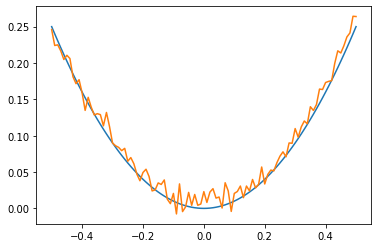

In [11]:
options = Options()
options.resilience_level = 0
options.optimization_level = 0
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": noisy_backend.configuration().coupling_map
}
options.execution.shots = 10000

executor_backend2 = Executor(Estimator(session,options),caching=False)
qnn_backend = QNNRegressor(pqc, op, executor_backend2, SquaredLoss(), Adam(), param_ini, param_op_ini)
qnn_backend.fit(x_space, ref_values)
x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = qnn_backend.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)

In [12]:
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": noisy_backend.configuration().coupling_map
}
options.execution.shots = 10000

# TODO set options for estimator and sampler in executor

executor_backend2 = Executor(Estimator(session,options),caching=False)
qnn_backend = QNNRegressor(pqc, op, executor_backend2, SquaredLoss(), Adam(), reg.param, reg.param_op)
x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = qnn_backend.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)

session closed!


C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:133: UserWarning: The model is not fitted.
  np.ndarray : The predicted values.
Traceback (most recent call last):
  File "C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\util\executor.py", line 501, in _primitive_run
    if job is None:
  File "C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\util\executor.py", line 632, in run
    def run():
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit_ibm_runtime\estimator.py", line 179, in run
    return super().run(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit\primitives\base\base_estimator.py", line 188, in run
    return self._run(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit_ibm_runtime\estimator.py", line 262, in _run
    return self._session.run(
  File "C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\

In [ ]:
options = Options()
options.resilience_level = 3
options.optimization_level = 0
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": noisy_backend.configuration().coupling_map
}
options.execution.shots = 10000

# TODO set options for estimator and sampler in executor

executor_backend3 = Executor(Estimator(session,options),caching=False)
qnn_backend = QNNRegressor(pqc, op, executor_backend3, SquaredLoss(), Adam(), reg.param, reg.param_op)
x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = qnn_backend.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)